# Load model

In [1]:
import pandas as pd
from birdclassification.training.dataset import BinaryDataset
from birdclassification.training.cnn_training_torch.CNN_model import CNNNetwork
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
from datetime import datetime
from birdclassification.training.validation_metrics import calculate_metric
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

SEED = 123
# BIRD_RECORDINGS_DIR = Path('/mnt/d/JAcek/recordings_30')
# NOT_BIRD_RECORDINGS_DIR = Path('/mnt/d/JAcek/NotBirds')

BIRD_RECORDINGS_DIR = Path('/media/jacek/E753-A120/recordings_30')
NOT_BIRD_RECORDINGS_DIR = Path('/media/jacek/E753-A120/NotBirds')

NOISES_DIR = Path('')
WRITER_DIR = Path('logs')
MODEL_PATH = Path('saved_models/model_20231210_175351_4')

SAMPLE_RATE = 32000
NUM_SAMPLES = SAMPLE_RATE * 1
BATCH_SIZE = 32
NUM_WORKERS = 8

LEARNING_RATE = 0.0001
EPOCHS = 5

/home/jacek/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
PATH = 'saved_models/model_20231210_175351_4'
cnn = CNNNetwork()
cnn.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
cnn.eval()

CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Sequential(
    (0): Linear(in_features=10880, out_features=2, bias=True)
  )
)

# Training

[Text(0.5, 0, 'Step (batch size = 32)'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Train loss')]

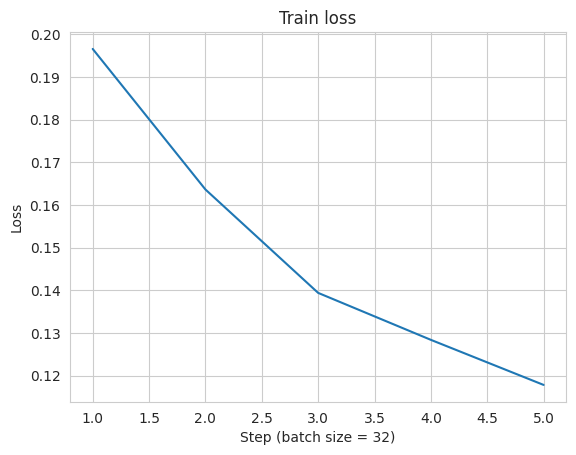

In [5]:
import seaborn as sns
train_loss_df = pd.read_csv('saved_models/model_20231210_175351.csv')
ax1 = sns.lineplot(data=train_loss_df, x="Step", y="Value")
ax1.set(xlabel='Step (batch size = 32)', ylabel='Loss', title = 'Train loss')

[Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Score'),
 Text(0.5, 1.0, 'Precision (macro)')]

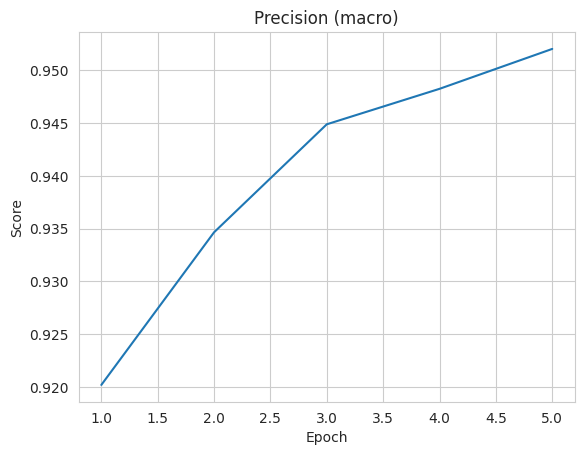

In [6]:
maf1 = pd.read_csv('saved_models/model_20231210_175351_Macro_averaged_precision_score_Validation.csv')
ax = sns.lineplot(data=maf1, x="Step", y="Value")
ax.set(xlabel='Epoch', ylabel='Score', title = "Precision (macro)")

/tmp/ipykernel_203643/3602276835.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(x="Step", y="Value", hue="split", ci="sd", data=combined_df)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'Loss')]

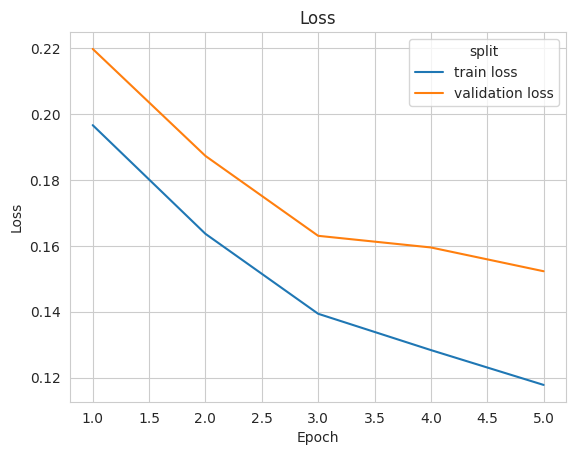

In [7]:

import seaborn as sns

loss_training_df = pd.read_csv('saved_models/model_20231210_175351_Training vs. Validation Loss_Training.csv')
loss_validation_df = pd.read_csv('saved_models/model_20231210_175351_Training vs. Validation Loss_Validation.csv')
loss_training_df['split'] = 'train loss'
loss_validation_df['split'] = 'validation loss'
loss_training_df = loss_training_df[['Step', 'Value', 'split']]
loss_validation_df = loss_validation_df[['Step', 'Value', 'split']]
combined_df = pd.concat([loss_training_df, loss_validation_df])
ax = sns.lineplot(x="Step", y="Value", hue="split", ci="sd", data=combined_df)
ax.set(xlabel='Epoch', ylabel='Loss', title = "Loss")

# Prepare dataset


In [8]:
df = pd.read_csv(Path("../../../data/data.csv"))

train_df, test_val_df = train_test_split(df, stratify=df['isBird'], test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['isBird'], test_size=0.5, random_state=SEED)

train_ds = BinaryDataset(train_df, bird_dir=BIRD_RECORDINGS_DIR, not_bird_dir=NOT_BIRD_RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=SAMPLE_RATE,
                        device=DEVICE)
val_ds = BinaryDataset(val_df, bird_dir=BIRD_RECORDINGS_DIR, not_bird_dir=NOT_BIRD_RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=32000, device=DEVICE)
test_ds = BinaryDataset(test_df, bird_dir=BIRD_RECORDINGS_DIR, not_bird_dir=NOT_BIRD_RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=32000, device=DEVICE)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

## Show spectrograms

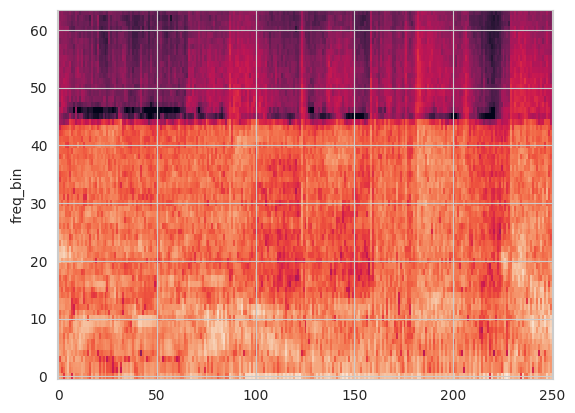

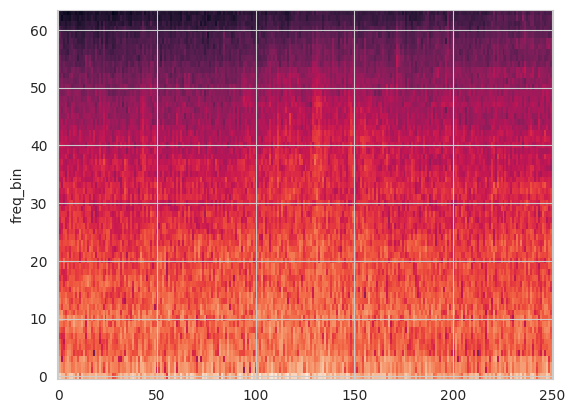

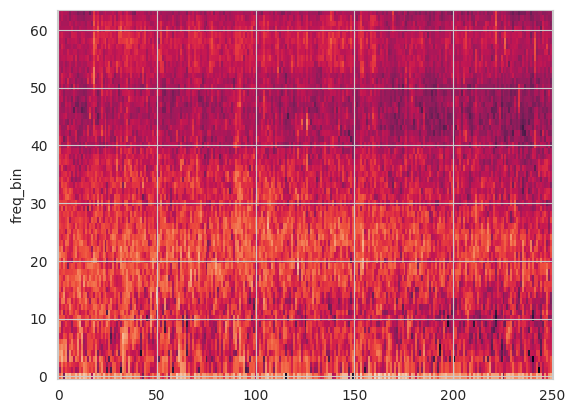

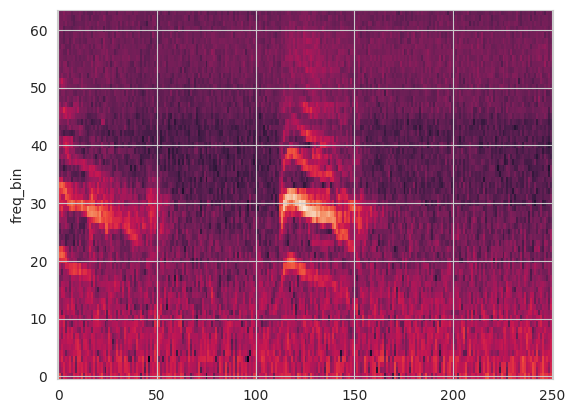

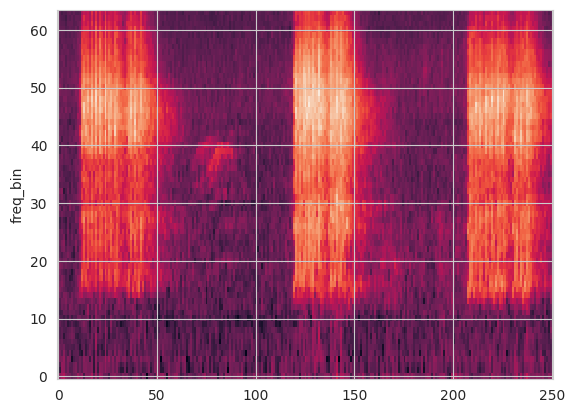

In [9]:
from birdclassification.visualization.plots import plot_torch_spectrogram

number_of_rec = 5
for i in range(number_of_rec):
    spectrogram, label = train_ds[i]
    plot_torch_spectrogram(spectrogram)

## Predict bird demo

In [10]:
names = list(train_ds.get_mapping().values())
names

['bird', 'not_bird']

Prediction:  bird


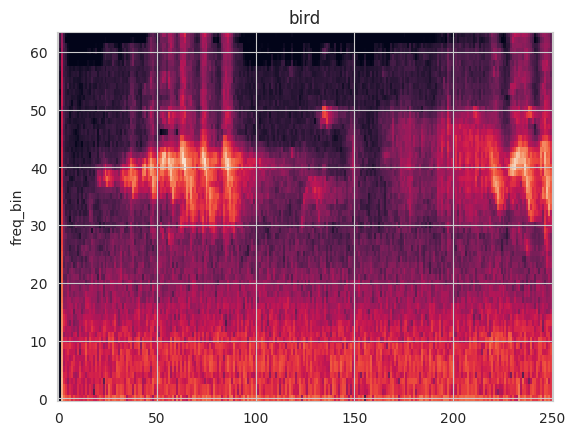

In [11]:
length_in_seconds = 3
sr = 32000
index = 6
map = train_ds.get_mapping()

cnn.eval()
with torch.no_grad():
    spectrogram, label = train_ds[index]
    plot_torch_spectrogram(spectrogram, title=map[label])
    spectrogram = torch.tensor(spectrogram)
    spectrogram = spectrogram.reshape([1, 1, 64, 251])
    validation_output = cnn(spectrogram)
    predictions = torch.max(validation_output, dim=1)[1].data.squeeze()
    
print("Prediction: ", train_ds.get_mapping()[predictions.item()])

# Validation

### Classification report

In [12]:
classification = calculate_metric(cnn, val_dl, device=DEVICE, metric=lambda x, y: classification_report(x, y, target_names=names))

In [13]:
print(0, classification)

0               precision    recall  f1-score   support

        bird       0.97      0.90      0.93      2833
    not_bird       0.94      0.98      0.96      4121

    accuracy                           0.95      6954
   macro avg       0.95      0.94      0.94      6954
weighted avg       0.95      0.95      0.95      6954


In [14]:
c_matrix = calculate_metric(cnn, val_dl, device=DEVICE, metric=confusion_matrix)

Text(95.58159722222221, 0.5, 'Prediction')

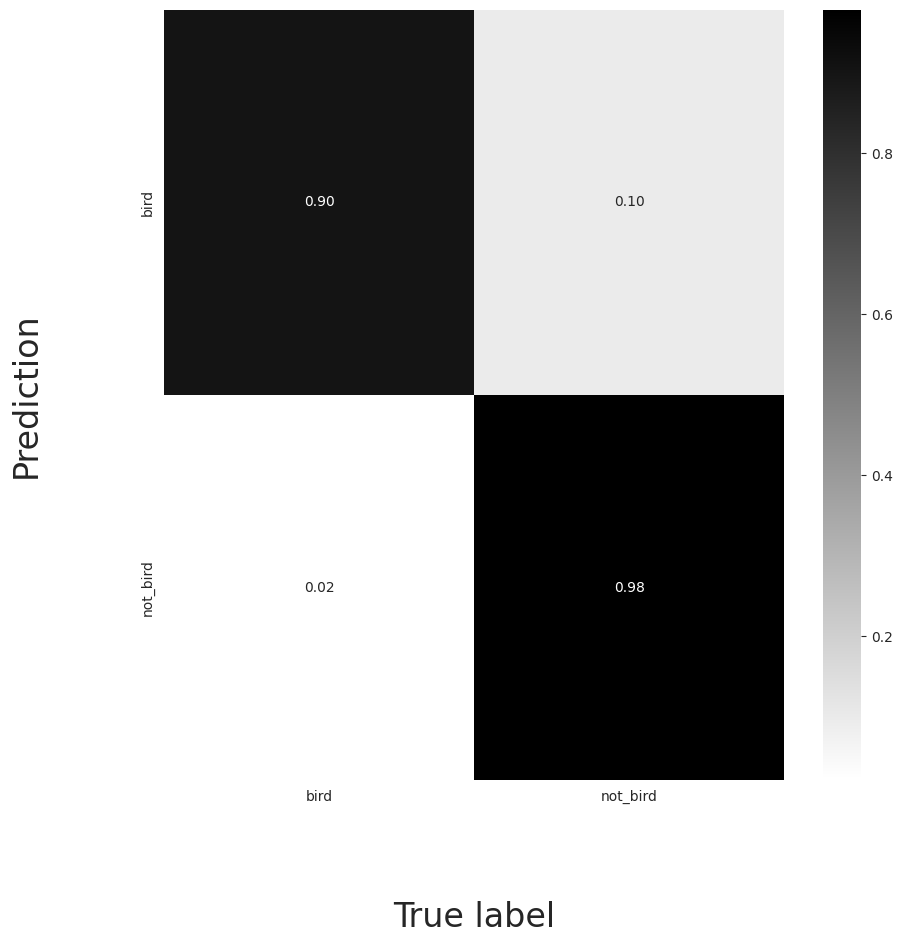

In [15]:
cm = c_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm)
df_cm.columns = train_ds.get_mapping().values()
df_cm.index = train_ds.get_mapping().values()
plt.figure(figsize = (10,10))
s = sns.heatmap(df_cm, annot=True, cmap = 'binary', fmt='.2f')
s.set_xlabel('True label', fontsize=24, labelpad=70)
s.set_ylabel('Prediction', fontsize=24, labelpad=70)
# s.set_title("Confusion matrix of predictions")

## Training

[Text(0.5, 0, 'Step (batch size = 32)'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Train loss')]

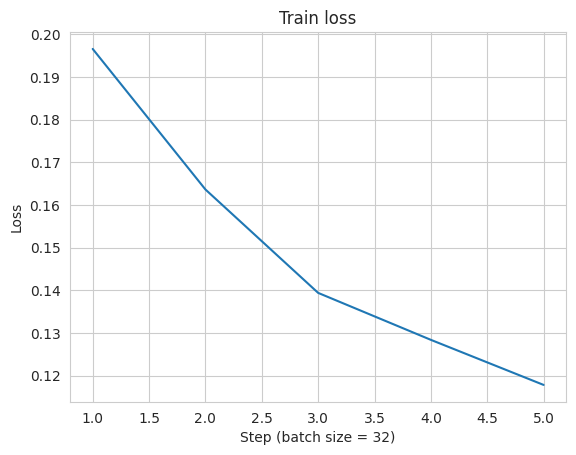

In [16]:
import seaborn as sns
train_loss_df = pd.read_csv('saved_models/model_20231210_175351.csv')
ax = sns.lineplot(data=train_loss_df, x="Step", y="Value")
ax.set(xlabel='Step (batch size = 32)', ylabel='Loss', title = 'Train loss')

[Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Score'),
 Text(0.5, 1.0, 'Precision (macro)')]

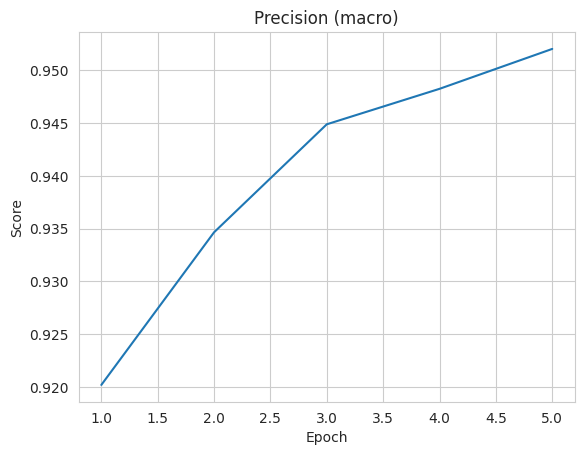

In [17]:
maf1 = pd.read_csv('saved_models/model_20231210_175351_Macro_averaged_precision_score_Validation.csv')
ax = sns.lineplot(data=maf1, x="Step", y="Value")
ax.set(xlabel='Epoch', ylabel='Score', title = "Precision (macro)")

/tmp/ipykernel_203643/2899840432.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(x="Step", y="Value", hue="split", ci="sd", data=combined_df)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'Loss')]

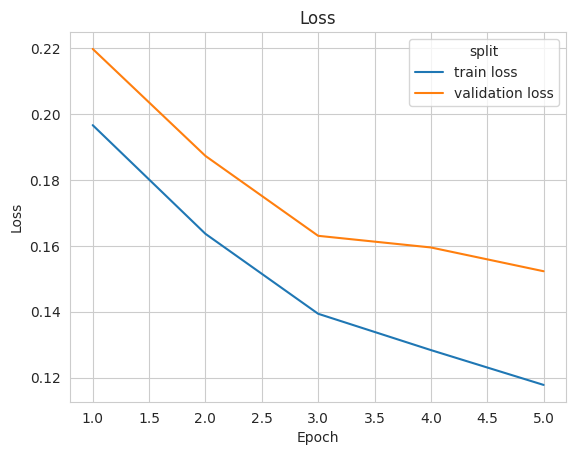

In [18]:
loss_training_df = pd.read_csv('saved_models/model_20231210_175351_Training vs. Validation Loss_Training.csv')
loss_validation_df = pd.read_csv('saved_models/model_20231210_175351_Training vs. Validation Loss_Validation.csv')
loss_training_df['split'] = 'train loss'
loss_validation_df['split'] = 'validation loss'
loss_training_df = loss_training_df[['Step', 'Value', 'split']]
loss_validation_df = loss_validation_df[['Step', 'Value', 'split']]
combined_df = pd.concat([loss_training_df, loss_validation_df])
ax = sns.lineplot(x="Step", y="Value", hue="split", ci="sd", data=combined_df)
ax.set(xlabel='Epoch', ylabel='Loss', title = "Loss")